# Deep Learning
## Summative assessment
### Coursework 1

#### Instructions

This coursework is released on **Tuesday 18th February 9.00** and is due by **Tuesday 11th March 9.00**. It is worth **50%** of your overall mark. There are 4 questions in this assessment, and a total of 50 marks are available. **You should attempt to answer all questions.** In addition to the total number of marks shown per question below, an additional 5 marks is available for presentation and clarity/quality of code.

This assessment assesses your ability to design, implement, train and evaluate a deep learning model for face verification. This is the problem of determining whether or not two images are of the same person.

You can make imports as and when you need them throughout the notebook, and add code cells where necessary. Make sure your notebook executes correctly in sequence before submitting.

The data required for this assessment can also be downloaded from [this link](https://drive.google.com/file/d/1guvJwIdHKi4-AFRPs0v-6kfHZhEuo8x8/view?usp=sharing) in case you would prefer to work locally.

#### Submission instructions

The submission for this assessment will consist of a notebook (.ipynb file) and PDF report.

Ensure your notebook executes correctly in order. Save your notebook .ipynb file **after you have executed it** (so that outputs are all showing). It is recommended to also submit a PDF/HTML copy of your executed notebook, in case the .ipynb file is corrupted for some reason.

Upload a zip file containing your notebook and separate PDF/HTML file(s) by the deadline above.

This assignment must be attempted individually; your submission must be your own, unaided work. Candidates are prohibited from discussing assessed coursework, and must abide by [Imperial College’s rules](https://www.imperial.ac.uk/media/imperial-college/administration-and-support-services/registry/academic-governance/public/academic-policy/academic-integrity/Examination-and-assessments---academic-integrity.pdf) regarding academic integrity and plagiarism. Unless specifically authorised within the assignment instructions, the submission of output from [generative AI tools](https://www.imperial.ac.uk/about/leadership-and-strategy/provost/vice-provost-education/generative-ai-tools-guidance/) (e.g., ChatGPT) for assessed coursework is prohibited. Violations will be treated as an examination offence. Enabling other candidates to plagiarise your work constitutes an examination offence. To ensure quality assurance is maintained, departments may choose to invite a random selection of students to an ‘authenticity interview’ on their submitted assessments.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import logging

# Suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [2]:
# You will need the following imports for this assessment. You can make additional imports
import keras
from keras import ops
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.models import Sequential
from keras.layers import Input, Dense

In [3]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    num_devices  = torch.cuda.device_count()
    for i in range(num_devices):
        device = torch.cuda.device(i)
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
        total_mem = torch.cuda.get_device_properties(device).total_memory
        print(f"Device {i}: {total_mem/1024**3:.2f}GB")

Device 0: NVIDIA RTX A6000
Device 0: 47.43GB


#### CASIA-Webface Dataset

This assessment makes use of the CASIA-Webface dataset, which is used for face verification and face identification tasks. The complete dataset consists of 494,414 face images of 10,575 real identities collected from the web. In this assessment, a smaller subset of the dataset has been prepared for you.

The dataset was first introduced in the following paper:

*  Yi, D., Lei, Z., Liao, S. and Li, S.Z. (2014), "Learning Face Representation from Scratch", arXiv preprint, abs/1411.7923.

The data subset is available for you in the folder `./data/casia-webface`.

#### Contrastive learning

Your task in this assessment is to develop a deep learning model that can be used to verify if two images belong to the same person or not. The model will take an image as input, and output a fixed size embedding. The model will be trained such that different images belonging to the same identity should have embeddings that are close to each other (in some sense), and images belonging to different identities should have embeddings that are far apart.

The training algorithm you will use for this will be a form of contrastive learning. This is a learning paradigm where the objective function compares different examples in the dataset.

In particular, to train your model you will use a loss function that takes three examples: an anchor input $\mathbf{x}$, a positive example $\mathbf{x}^+$ that is similar to the anchor (the same identity), and a negative example $\mathbf{x}^-$ that is different to the anchor. The objective for the network is to embed the images such that the similarity between the anchor and positive example is maximised (or distance is minimised), and the similarity between the anchor and negative example is minimised (distance is maximised).

<center><img src="figures/contrastive-learning.png" alt="Similarity of representations" style="width: 450px;"/></center>
<center>The model's objective is to minimize the distance (in embedding space) between an anchor and a positive example, both of which have the same identity, and maximize the distance between the anchor and a negative example of a different identity</center>
<br>

The loss function you will use is the circle loss, given by:

$$
\mathcal{L}_{\textrm{circle}}(s_p, s_n) = \frac{1}{\gamma}\log\left[ 1 + \exp(\gamma (\alpha_n(s_n - \Delta_n) - \alpha_p(s_p - \Delta_p))\right],
$$
where $s_p$ (resp. $s_n$) is the positive (resp. negative) similarity score computed between the anchor and positive (resp. anchor and negative) examples, according to some choice of similarity measure in the embedding space. The hyperparameters $\alpha_p>0$ and $\alpha_n>0$ are example-specific weightings to emphasise either the positive or negative similarity scores in the gradient updates, and $\Delta_p>0$ and $\Delta_n>0$ are the positive and negative margins. 

The circle loss was introduced in the following paper:

* Sun, Y., Cheng, C., Zhang, Y., Zhang, C., Zheng, L. and Wang, Z. (2020), "Circle Loss: A Unified Perspective of Pair Similarity Optimization," *IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), Seattle, WA, USA*, 6397-6406.

You will need to implement a custom data loading pipeline and custom training loop, as well as designing a dedicated model architecture that produces an embedding for a given input image. Details of the data loading and training procedures will be up to you to decide. You will process the data, train and evaluate the specified model, and then write a report to summarise the experiments and results.

The data processing, model design, training algorithm and evaluation will potentially require several hyperparameter choices, and you should experiment with different choices during the development of your model. In question 4 you will write a report detailing the experiments carried out. It is up to you which experiments you will run. It is not necessary to include all experiments carried out in code in this notebook - you only need to include the code for the final choice of hyperparameters (in order to avoid overly long notebook submissions).

### Question 1 (Total 8 marks)

a) In this question, you should carry out a basic exploration and analysis of the dataset; computing, displaying and visualising any properties you deem to be relevant. For example, it will be helpful to compute the number of distinct identities in the dataset, and visualise some of the images. You can also use comments and/or markdown as appropriate.

**(3 marks)**

Total number of distinct identities: 8000
Total number of images: 211958


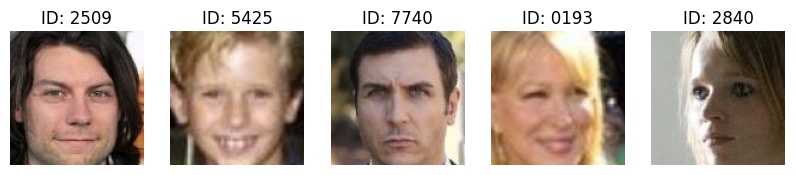

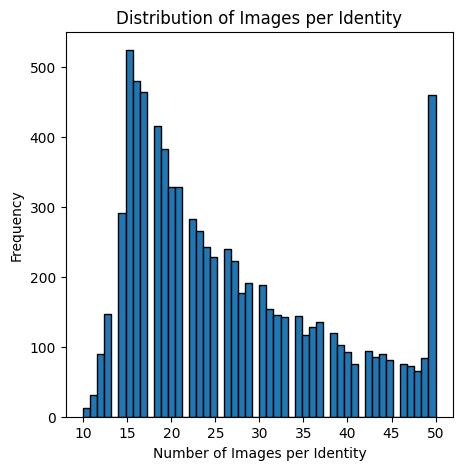

In [4]:
dataset_path = "data/casia-webface"
import random
import cv2

# Get list of identities (folders)
identities = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
num_identities = len(identities)

# Count the number of images per identity
image_counts = {identity: len(os.listdir(os.path.join(dataset_path, identity))) for identity in identities}
total_images = sum(image_counts.values())

print(f"Total number of distinct identities: {num_identities}")
print(f"Total number of images: {total_images}")

# Display some sample images
def display_sample_images(dataset_path, identities, num_samples=5):
    plt.figure(figsize=(10, 5))
    sampled_identities = random.sample(identities, min(num_samples, len(identities)))
    
    for i, identity in enumerate(sampled_identities):
        image_files = os.listdir(os.path.join(dataset_path, identity))
        if not image_files:
            continue
        image_path = os.path.join(dataset_path, identity, random.choice(image_files))
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"ID: {identity}")
        plt.axis("off")
    
    plt.show()

display_sample_images(dataset_path, identities)

# Plot a histogram of image counts per identity
plt.figure(figsize=(5, 5))
plt.hist(image_counts.values(), bins=50, edgecolor='black')
plt.xlabel("Number of Images per Identity")
plt.ylabel("Frequency")
plt.title("Distribution of Images per Identity")
plt.show()


There are 8000 distinct identities. Some identities (500 out of 8000) have 50 images, 
while most identities have 15-20 images.

Most populated identity: 6220 (50 images)


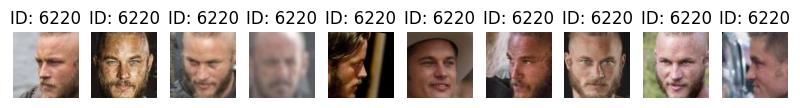

Least populated identity: 1816 (10 images)


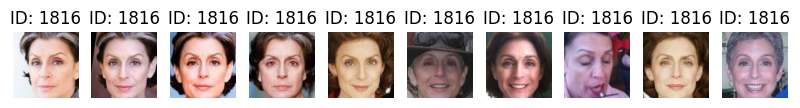

In [5]:
from PIL import Image
# Get the most and least populated identities
most_populated = max(image_counts, key=image_counts.get)
least_populated = min(image_counts, key=image_counts.get)

def display_images_from_identity(identity, num_samples=5):
    plt.figure(figsize=(10, 5))
    image_files = os.listdir(os.path.join(dataset_path, identity))
    sampled_images = random.sample(image_files, min(num_samples, len(image_files)))

    for i, img_name in enumerate(sampled_images):
        img_path = os.path.join(dataset_path, identity, img_name)
        img = Image.open(img_path)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"ID: {identity}")
        plt.axis("off")

    plt.show()

print(f"Most populated identity: {most_populated} ({image_counts[most_populated]} images)")
display_images_from_identity(most_populated, 10)

print(f"Least populated identity: {least_populated} ({image_counts[least_populated]} images)")
display_images_from_identity(least_populated, 10)


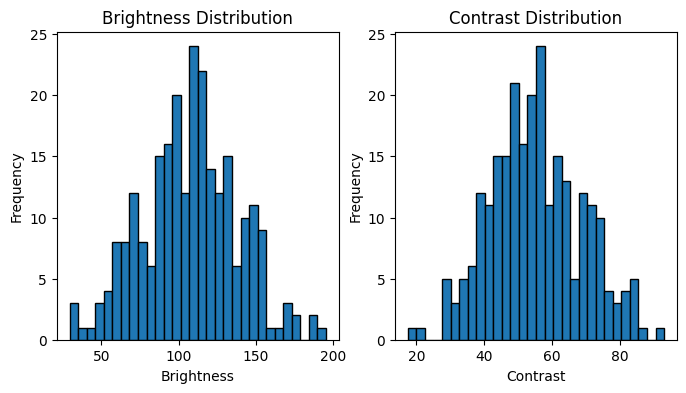

In [6]:
def compute_brightness_contrast(image_path):
    img = Image.open(image_path).convert("L")  # Convert to grayscale
    img_array = np.array(img)
    brightness = np.mean(img_array)
    contrast = np.std(img_array)
    return brightness, contrast

brightness_vals, contrast_vals = [], []

for identity in random.sample(identities, min(len(identities), 50)):
    image_files = os.listdir(os.path.join(dataset_path, identity))
    for img_name in random.sample(image_files, min(len(image_files), 5)):
        img_path = os.path.join(dataset_path, identity, img_name)
        b, c = compute_brightness_contrast(img_path)
        brightness_vals.append(b)
        contrast_vals.append(c)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(brightness_vals, bins=30, edgecolor="black")
plt.xlabel("Brightness")
plt.ylabel("Frequency")
plt.title("Brightness Distribution")

plt.subplot(1, 2, 2)
plt.hist(contrast_vals, bins=30, edgecolor="black")
plt.xlabel("Contrast")
plt.ylabel("Frequency")
plt.title("Contrast Distribution")

plt.show()

We also want to check the shape of each image.

In [7]:
image_shapes = []

for identity in identities[:3]:  # Check 3 random identities
    image_files = os.listdir(os.path.join(dataset_path, identity))
    
    for img_name in image_files[:2]:  # Check 2 images per identity
        img_path = os.path.join(dataset_path, identity, img_name)
        with Image.open(img_path) as img:
            print(f"Image: {img_name}, Size: {img.size}")  # img.size gives (width, height)
            image_shapes.append(img.size)

print("Unique image shapes:", set(image_shapes))


Image: 000005.jpeg, Size: (112, 112)
Image: 000001.jpeg, Size: (112, 112)
Image: 000002.jpeg, Size: (112, 112)
Image: 000006.jpeg, Size: (112, 112)
Image: 000036.jpeg, Size: (112, 112)
Image: 000007.jpeg, Size: (112, 112)
Unique image shapes: {(112, 112)}


b) Create the dataset object(s) that you will use to train and evaluate your model. The only requirements for your datasets are as follows:

* You should use either TensorFlow Datasets or PyTorch Datasets/DataLoaders. 
* A number of identities should be selected, and for each identity a maximum number of images should be selected.
* The dataset should return an aligned pair of Tensors `(identities, images)` with shapes `(N,)` and `(N, height, width, channels)`, where `N` is the total number of images selected across all selected identities.

You can use any tools from Keras, TensorFlow or PyTorch that might be useful for this task.

Demonstrate that your dataset creation and processing is working as intended.

**(5 marks)**

In [8]:
!export CUDA_VISIBLE_DEVICES=0  # Use only GPU 0
from tensorflow.keras.utils import Sequence

class KerasFaceDataset(Sequence):
    """
    Keras-compatible dataset that:
      - Takes a list of identity folders
      - Selects up to max_images_per_identity from each folder
      - Returns batches of (images, labels) in (N, 112, 112, 3) format
    """
    def __init__(self, dataset_path, identities, max_images_per_identity=10,
                 batch_size=32, shuffle=True):
        self.dataset_path = dataset_path
        self.identities = identities
        self.max_images_per_identity = max_images_per_identity
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.image_paths = []
        self.labels = []
        
        # Collect image paths and their identity labels
        for idx, identity in enumerate(identities):
            identity_folder = os.path.join(dataset_path, identity)
            image_files = os.listdir(identity_folder)
            # Select the first `max_images_per_identity` images from each identity
            selected_images = image_files[:max_images_per_identity]
            for img_name in selected_images:
                self.image_paths.append(os.path.join(identity_folder, img_name))
                self.labels.append(idx)
        
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()  # Shuffle at the start if needed

    def __len__(self):
        """
        Number of batches per epoch.
        """
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def on_epoch_end(self):
        """
        Shuffle indexes after each epoch if needed.
        """
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        """
        Generates one batch of data.
        """
        # Generate batch indexes
        batch_indexes = self.indexes[index * self.batch_size:
                                     (index + 1) * self.batch_size]
        
        batch_paths = [self.image_paths[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]

        # Load and transform images
        images = []
        for path in batch_paths:
            # Load and convert to RGB
            img = Image.open(path).convert("RGB")
            # Resize to 112x112
            img = img.resize((112, 112), resample=Image.BILINEAR)
            # Convert to NumPy array in [0, 255]
            img = np.array(img, dtype=np.float32)
            # Scale to [0, 1]
            img /= 255.0
            images.append(img)

        # Convert to (batch_size, 112, 112, 3)
        images = np.stack(images, axis=0)
        
        # Convert labels to NumPy
        labels = np.array(batch_labels, dtype=np.int32)
        
        return images, labels

import tensorflow as tf

# Build dataset
train_identities = identities[:100]  # Take a subset for demonstration
train_dataset = KerasFaceDataset(
    dataset_path=dataset_path,
    identities=train_identities,
    max_images_per_identity=10,
    batch_size=32,
    shuffle=True
)
# check shape
for images, labels in train_dataset:
    print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
    break



/usr/lib64/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Images shape: (32, 112, 112, 3), Labels shape: (32,)


### Question 2 (Total 20 marks)

a) Recall the circle loss is given by

$$
\mathcal{L}_{\textrm{circle}}(s_p, s_n) = \frac{1}{\gamma}\log\left[ 1 + \exp(\gamma (\alpha_n(s_n - \Delta_n) - \alpha_p(s_p - \Delta_p))\right],\tag{1}
$$

where $\alpha_p>0$, $\alpha_n>0$, $\Delta_p>0$ and $\Delta_n>0$ are hyperparameters, and $s_p$ and $s_n$ are the similarity scores between anchor-positive and anchor-negative pairs according to some similarity measure.

The [triplet loss](https://en.wikipedia.org/wiki/Triplet_loss) is a similar loss function for contrastive learning that was developed a few years earlier. It is given by:

$$
\mathcal{L}_{\textrm{triplet}}(\mathbf{x}, \mathbf{x}^+, \mathbf{x}^-) =  \max(0, || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+) ||_2^2 - || f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-) ||_2^2  + m)\tag{2}
$$

where $f_\theta$ is a network that maps images to a fixed-size embedding, $\mathbf{x}$ is an anchor example, $\mathbf{x}^+$ is a corresponding positive example, and $\mathbf{x}^-$ is a negative example, and $m>0$ is a hyperparameter that sets the minimum offset between distances of similar vs dissimilar pairs. 

Show that the triplet loss can be derived from the circle loss as a certain limit, with a certain choice of hyperparameters $\alpha_p$, $\alpha_n$, $\Delta_p$ and $\Delta_n$ and similarity measure.

**(2 marks)**

We know that the Softplus function $ \log(1 + e^z) $ is an approximation of ReLU: $\max(0, z)$

When we scale it with $\gamma$, the transition at 0 gets sharper until it behaves like $\max(0, z)$ when $ \gamma \to \infty$:
$$
\max(0,\,z) = Relu(z) =
\lim_{\gamma\to\infty}\;\frac{1}{\gamma}\,\log\bigl(1 + e^{\gamma\,z}\bigr).
$$
Hence as $\gamma \to \infty$:
$$
\mathcal{L}_{\textrm{circle}}(s_p, s_n) \to \max\bigl(0,\;\alpha_n\,(s_n - \Delta_n) - \alpha_p\,(s_p - \Delta_p)\bigr)
$$

Let
$$
s_p 
= 
-\frac{\,\bigl\|\!f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+)\bigr\|_2^2}{\alpha_p},
\quad
s_n 
= 
-\frac{\,\bigl\|\!f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-)\bigr\|_2^2}{\alpha_n}.
$$
$$
\Delta_p = -\,\frac{m}{2\,\alpha_p}, 
\quad
\Delta_n = \frac{m}{2\,\alpha_n},
$$

Then
$$
\alpha_p\,(s_p - \Delta_p)
= 
-\,\|f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+)\|_2^2 \;+\;\frac{m}{2},
$$
$$
\alpha_n\,(s_n - \Delta_n)
=
-\,\|f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-)\|_2^2 \;-\;\frac{m}{2}
$$

so that
$$
\alpha_n\,(s_n - \Delta_n) \;-\;\alpha_p\,(s_p - \Delta_p)
=
-\,\|f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-)\|_2^2 
\;+\;
\|f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+)\|_2^2
\;+\; m.
$$

Therefore,
$$
\mathcal{L}_{\mathrm{circle}}(s_p, s_n)
\;\;\xrightarrow[\gamma\to\infty]{}\;\;
\max\Bigl(0,\;
\|f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^+)\|_2^2
\;-\;
\|f_\theta(\mathbf{x}) - f_\theta(\mathbf{x}^-)\|_2^2
\;+\; m
\Bigr),
$$


b) You will use the circle loss to train your model. Following Sun et al., we will assume that the similarity score takes values between 0 and 1. A suitable choice of similarity measure that satisfies this is the scaled cosine similarity $s(\mathbf{x}_1, \mathbf{x}_2) = (\langle \mathbf{x}_1, \mathbf{x}_2 \rangle + 1) / 2$, where $\mathbf{x}_1$ and $\mathbf{x}_2$ have been normalised such that $||\mathbf{x}_1||_2 = ||\mathbf{x}_2||_2 = 1$.

With this choice, typical settings for the hyperparameters in the circle loss are

$$
\begin{align}
\alpha_p &= 1 + m - s_p\\
\alpha_n &= s_n + m\\
\Delta_p &= 1 - m\\
\Delta_n &= m
\end{align}
$$

where $0<m<1$ is the _margin_. These settings reduce the hyperparameters in the loss function to just one (the margin $m$).

Write a function `circle_loss` to implement the circle loss as described above. Your loss function implementation should therefore take the following arguments:

* `anchor_embeddings`, a Tensor of shape `(N, d)`: the $\ell_2$-normalised model embeddings for the anchor images
* `positive_embeddings`, a Tensor of shape `(N, d)`: the $\ell_2$-normalised model embeddings for the corresponding positive images
* `negative_embeddings`, a Tensor of shape `(N, d)`: the $\ell_2$-normalised  model embeddings for the corresponding negative images
* `m`, a float value between zero and 1: the margin
* `gamma`, a positive float: scaling hyperparameter in the circle loss

**(2 marks)**

We note that in this case, the circle loss is given by
$$
\mathcal{L}_{\textrm{circle}}(s_p, s_n) = \frac{1}{\gamma}\log\left[ 1 + \exp(\gamma z\right)]
$$
Where
$$
z = s_n^2 + (s_p - 1)^2 - 2m^2
$$

In [9]:
import torch
import torch.nn.functional as F

def circle_loss_torch(anchor_embeddings, positive_embeddings, negative_embeddings, m=0.25, gamma=64.0):
    # -- Step 1: Compute scaled cosine similarities in [0, 1].
    s_p = ((anchor_embeddings * positive_embeddings).sum(dim=1) + 1.0) / 2.0
    s_n = ((anchor_embeddings * negative_embeddings).sum(dim=1) + 1.0) / 2.0

    alpha_p = 1.0 + m - s_p
    alpha_n = s_n + m
    delta_p = 1.0 - m
    delta_n = m

    # We'll compute this in a vectorized way and then average across the batch.
    inside_term = gamma * (alpha_n * (s_n - delta_n) - alpha_p * (s_p - delta_p))
    losses = (1.0 / gamma) * torch.log1p(torch.exp(inside_term))  # log1p(x) = log(1 + x)
    
    return losses.mean()

# Example usage
anchor = F.normalize(torch.randn(1, 5), p=2, dim=1)
pos = F.normalize(torch.randn(1, 5), p=2, dim=1)
neg = F.normalize(torch.randn(1, 5), p=2, dim=1)

loss_value = circle_loss_torch(anchor, pos, neg, m=0.25, gamma=64.0)
print(f"Circle loss = {loss_value.item():.4f}")


Circle loss = 0.7984


In [10]:
def circle_loss(anchor_embeddings, positive_embeddings, negative_embeddings, m=0.25, gamma=64.0):
    s_p = (tf.reduce_sum(anchor_embeddings * positive_embeddings, axis=1) + 1.0) / 2.0
    s_n = (tf.reduce_sum(anchor_embeddings * negative_embeddings, axis=1) + 1.0) / 2.0
    z =  s_n**2 + (s_p - 1)**2 - 2 * m ** 2
    losses = (1.0 / gamma) * tf.math.log1p(tf.exp(gamma * z))  # log1p(x) = log(1 + x)
    # if multiple samples, return mean loss
    return tf.reduce_mean(losses)

loss_value = circle_loss(anchor.numpy(), pos.numpy(), neg.numpy(), m=0.25, gamma=64.0)
print(f"Circle loss = {loss_value.numpy():.4f}")


Circle loss = 0.7984


I0000 00:00:1740477488.193325 2571812 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


c) You should design and implement a model that will be trained on the face verification task, using the circle loss defined above. 

The only specifications for your model is that it should take a batch of images as input, and return a batch of embeddings as output. Each embedding will be a fixed-size vector in $\mathbb{R}^d$ (and you are also free to choose $d$). The embeddings should be normalised to have unit $\ell_2$ norm.

Your model should be defined entirely using Keras. Print the model summary to show details of your chosen design.

**(3 marks)**

d) You should now write a function `get_triplets` that will take a batch of data from your dataset, along with the model, and any other options that you need to pass in. This function should return a list of tuples, where each tuple consists of three integers `(anchor_index, positive_index, negative_index)`. These three integers should correspond to batch indices in your data for anchor, positive and negative images respectively.

There are several ways that triplets can be selected from a batch of data, and the selection criteria often has a significant effect on the model training. It is recommmended that you experiment with different methods for triplet selection. 

A common strategy is to select triplets based on similarity scores that are being predicted by the model at a given stage in the training. This is done to ensure that the selected triplets provide an appropriate level of difficulty for the model. 

Demonstrate your function is working correctly by applying it to a batch of data and your (randomly initialised) model, and displaying some of the triplets selected.

*Hint: The FaceNet paper (which introduced the triplet loss in question 2a) contains some suggestions for triplet selection, which you might find useful to look at:*

* Schroff, F., Kalenichenko, D. and Philbin, J. (2015), "FaceNet: A unified embedding for face recognition and clustering," *IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Boston, MA, USA*, 815-823.

**(7 marks)**

e) You should now write and execute a custom training loop to train your model. Your custom training loop should use the `circle_loss` and `get_triplets` functions defined in parts b) and c).

Your custom training loop should use a Keras optimizer to perform the gradient updates. It should also record performance metrics as the training progresses. It is advised to structure your training loop to regularly save your model during training.

Display the final loss and any other performance metrics for your best trained model.

**(6 marks)**

#### Question 3 (Total 7 marks)

In this question you will view your trained model as a binary classifier that predicts whether two images are the same person or not. You will test your trained model on a subset of the Labeled Faces in the Wild (LFW) dataset. This dataset also consists of a number of identities, and a number of images per identity. It was introduced in the following paper:

* Huang, G.B., Ramesh, M., Berg, T., and Learned-Miller, E. (2007), "Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments", University of Massachusetts, Amherst, Technical Report 07-49.

The subset is available for you in the folder `./data/labeled-faces-in-the-wild`.  There is also the file `lfw_test_pairs.txt` in the `./data` folder that you will use for testing. This file lists a number of pairs of images in the LFW dataset that either belong to the same identity or different identities.

_NB: if you have not been able to successfully train a model in question 2, you can still complete all of question 3 using any Keras model that takes images as input and returns embeddings. The results may not be good, but you can still demonstrate the methodology and implementation for testing the model._

a) You will now use your best model from question 2 to compute predictions on the LFW subset to say whether or not two images are the same person. 

Apply any appropriate data preprocessing to the images, and compute model embeddings and similarity scores for all images in the test data.

Display a histogram with the distribution of positive and negative similarity scores from your model.

**(4 marks)**

b) Use the computed similarity scores from part a) to calculate the area under the ROC curve and the area under the precision-recall (PR) curve for your classifier model. Use the Keras `AUC` metric (see [the docs](https://keras.io/api/metrics/classification_metrics/#auc-class)) to do this.

Compute the threshold that maximises the accuracy of your classifier on the LFW test data. Plot the accuracy as a function of the threshold, and report the optimal threshold and resulting accuracy.

**(3 marks)**

#### Question 4 (Total 10 marks)

Provide a separate PDF report with an account of the experiments you have run in question 2. Your report should include details of the choices you have made throughout the development of the models, including the data processing, architecture design, hyperparameter settings/experiments and training algorithm. Where appropriate, you can also provide your intuition behind these choices. 

Your report should also include the results from your experiments, highlighting the best choice of hyperparameters that you found. If you encountered difficulties to successfully train the model(s) you should report these, and if possible suggest what you think might be potential reasons for these difficulties. Are there additional experiments or modifications to the model and/or training algorithm that you would have liked to make given more time? What do you think are the most promising directions for performance gains?

Marks will be awarded for presentation and clarity. Your report should be no more than 3 pages, excluding references.

**(10 marks)**